In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from ztffps import get_cycle, get_lightcurve
import pandas as pd
from read_swift import read_swift_data

%matplotlib notebook

In [2]:
sources = pd.read_csv('sources', comment='#')
sources

,name,time,time2,A_tel,A_tel2
0,MAXI J1820+070,58188.534722,0.000000,11399,0
1,Swift J1858.6-0814,58416.000000,0.000000,12151,0
2,Swift J1357.2-0933,58626.577083,59320.059722,12801,14573
3,Aquila X-1,58702.000000,59081.684000,13016,13961
4,XTE J1859+226,59252.000000,0.000000,14375,0
5,Swift J1910.2-0546,59614.000000,0.000000,15214,0
6,MAXI J1957+032,59748.726390,0.000000,15440,0
7,IGR J17591-2342,58341.000000,0.000000,11941,0
8,EXO 1846-031,58687.863890,0.000000,12968,0
9,SRGt J071522.1-191609,58958.060000,0.000000,13657,0


## Function to plot x-ray data over optical forced photometry

In [1]:
def xray_overplot(obj='', start_time=0, start_time2=0, include_bat = True, include_maxi=True, include_wt = False, mkr_size=3, legend=True):
    
    # set up plot
    fig, ax1 = plt.subplots()
    fig.set_size_inches(9,7)
    fig.tight_layout()
    plt.title(obj)
    ax1.set_xlabel('MJD')

    # Read in ZTF optical data
    phot_file = f'ztf_data/{obj}.txt'
    colors = ['green', 'pink', 'red']
    ztf_fp = get_lightcurve(phot_file)
    wr = ztf_fp['filter'] == 'ZTF_r'
    wg = ztf_fp['filter'] == 'ZTF_g'
    color = 'tab:red'
    
    # plot optical data
    ax1.set_ylabel('mag', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.invert_yaxis()
    ax1.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
                 ztf_fp.loc[wr,'dc_mag_err'],fmt='o',ls='none', markersize=mkr_size, color=colors[2], label='ztf-r')
    ax1.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25, s=mkr_size,
                edgecolor='none',color=colors[2], label='r limit')
    ax1.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
                 ztf_fp.loc[wg,'dc_mag_err'],fmt='o',ls='none', markersize=mkr_size,color=colors[0], label='ztf-g')
    ax1.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25, s=mkr_size,
                edgecolor='none',color=colors[0], label='g limit')
        
    # Read in SWIFT x-ray data
    xray_file = f'swift_data/{obj}_xray.txt'
    swift_pc, uplim, swift_wt= read_swift_data(xray_file)
    
# with MJD format    
#     swift = pd.read_csv(f'swift_data/{xray_file}', sep="\s+", skiprows=[0,1,2,3,4,5,6,7])
#     swift.rename(columns={"!MJD":"MJD", "T_+ve":"Tpos", "T_-ve":"Tneg"}, inplace=True)
#     blank_rows = np.append(swift.query('MJD == "!"').index.values, swift.query('MJD == "NO"').index.values)
#     swift.drop(blank_rows, inplace=True)   # delete all comment & blank rows
    
    # change column values from strings to floats 
    for i in swift_pc.columns:
        swift_pc[f'{i}'] = pd.to_numeric(swift_pc[f'{i}'])  
    for i in uplim.columns:
        uplim[f'{i}'] = pd.to_numeric(uplim[f'{i}'])
    for i in swift_wt.columns:
        swift_wt[f'{i}'] = pd.to_numeric(swift_wt[f'{i}'])

    # set errorbars
    ybars_pc=(-swift_pc['Rateneg'], swift_pc['Ratepos'])
    # xbars=(-swift['T_-ve'], swift['T_+ve'])
    ybars_wt = (-swift_wt['Rateneg'], swift_wt['Ratepos'])

    # plot x-ray data
    ax2 = ax1.twinx()
    color2 = 'blue'
    ax2.set_ylabel('Count Rate', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.errorbar(swift_pc['Time'], swift_pc['Rate'], yerr=ybars_pc, alpha=.8, fmt='o', color=color2, markersize= mkr_size, label='X-ray counts')
    ax2.errorbar(uplim['Time'], uplim['Rate'], fmt='v', color=color2, alpha=.8, markersize= mkr_size+2, label='swift upper limit')
    
    # plot first x-ray detection time (from ATel)
    ax2.axvline(x=start_time, ls='--',color=color2, label='First x-ray detection')
    ax2.axvline(x=start_time2, ls='--', color=color2)
    
    # option to include wt data (swift)
    if include_wt == True:
        ax2.errorbar(swift_wt['Time'], swift_wt['Rate'], yerr=ybars_wt, alpha=.8, fmt='o', color=color2, markersize= mkr_size)
    
    # SWIFT-BAT data
    if include_bat==True:
        bat=pd.read_csv(f'bat_data/{obj}_bat.txt', names=['time', 'rate', 'error','year','day','stat_err','sys_err','data_flag','timedel_expo','timedel_coded','timedel_dithered'],
                        comment='#', delim_whitespace=True)
        std_bat = np.std(bat['rate'])
        if std_bat != std_bat: std_bat=0
        bat = bat.query(f"rate>{std_bat*3}")
        ax2.errorbar(bat['time'], bat['rate'], alpha=.8, fmt='o', color='m', markersize= mkr_size, label='SWIFT-BAT')
        
    # MAXI data
    if include_maxi==True:
        maxi = pd.read_csv(f'maxi_data/{obj}_maxi.txt', names=['MJDcenter', 'counts', '2-20 err', '2-4keV', '2-4 err', '4-10keV', '4-10 err', '10-20keV', '10-20 err' ],
                   comment='#', delim_whitespace=True)
        std_maxi = np.std(maxi["counts"])
        if std_maxi != std_maxi: std_maxi=0
        maxi = maxi.query(f"counts > {std_maxi*3}")
        ax2.errorbar(maxi['MJDcenter'], maxi['counts'], alpha=.8, fmt='o', color='k', markersize= 3, label='MAXI')
    
    # finish plot
    if legend == True:
        ax1.legend(loc=2)
        ax2.legend(loc=1)
    ax2.set_yscale('log')
    plt.xlim([58000, 60200])
    
    plt.show()  

## Display plots & ATel links

<IPython.core.display.Javascript object>


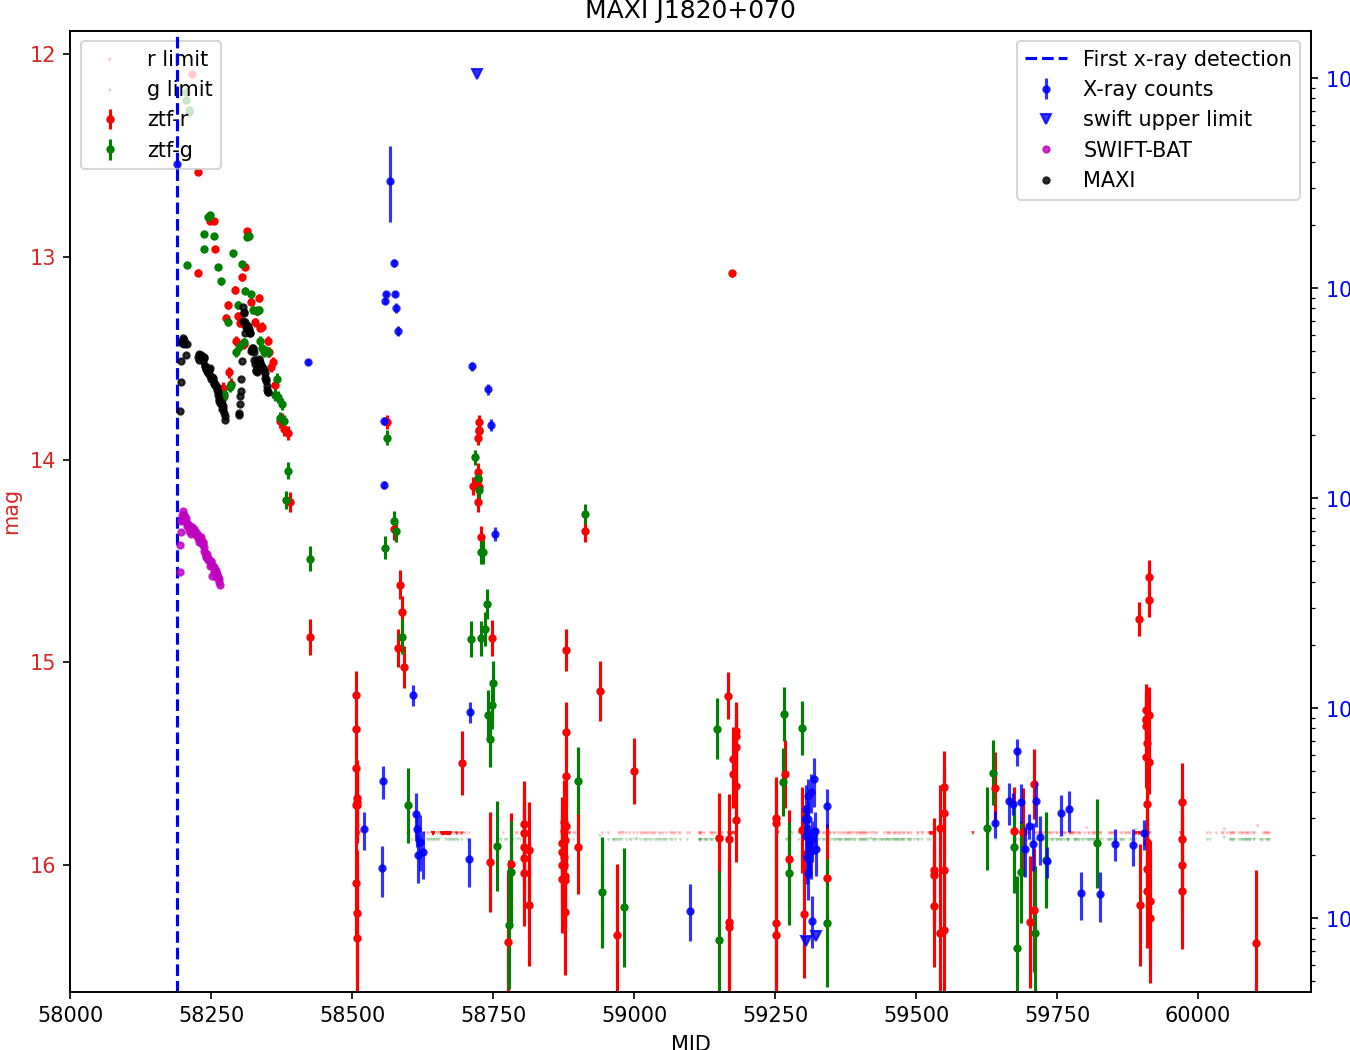

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 11399
https://www.astronomerstelegram.org/?read=11399


<IPython.core.display.Javascript object>


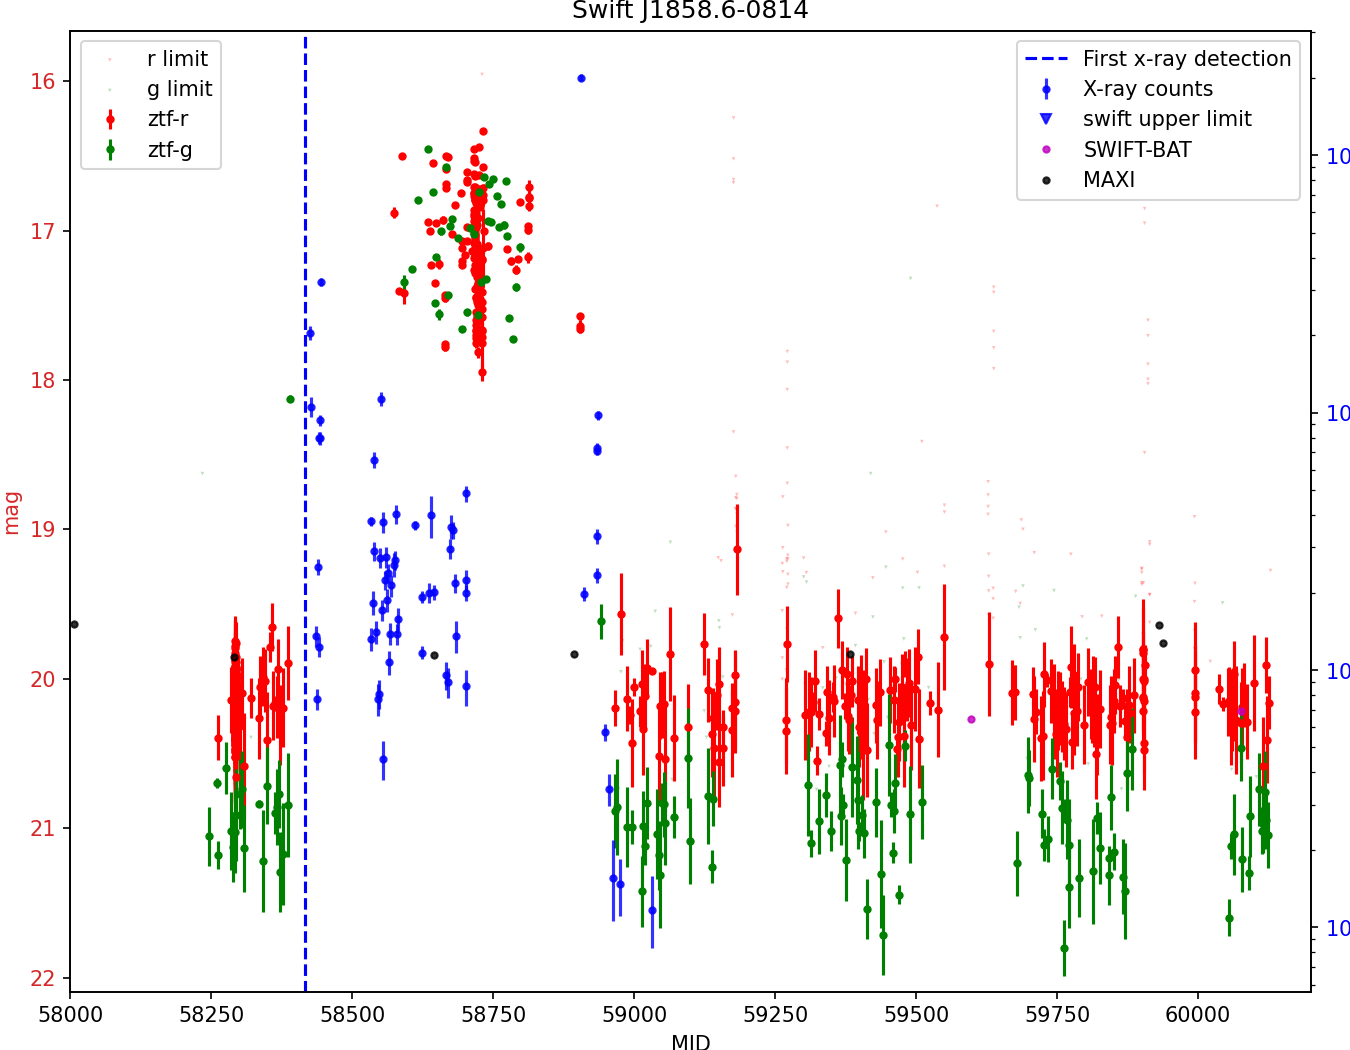

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 12151
https://www.astronomerstelegram.org/?read=12151


<IPython.core.display.Javascript object>


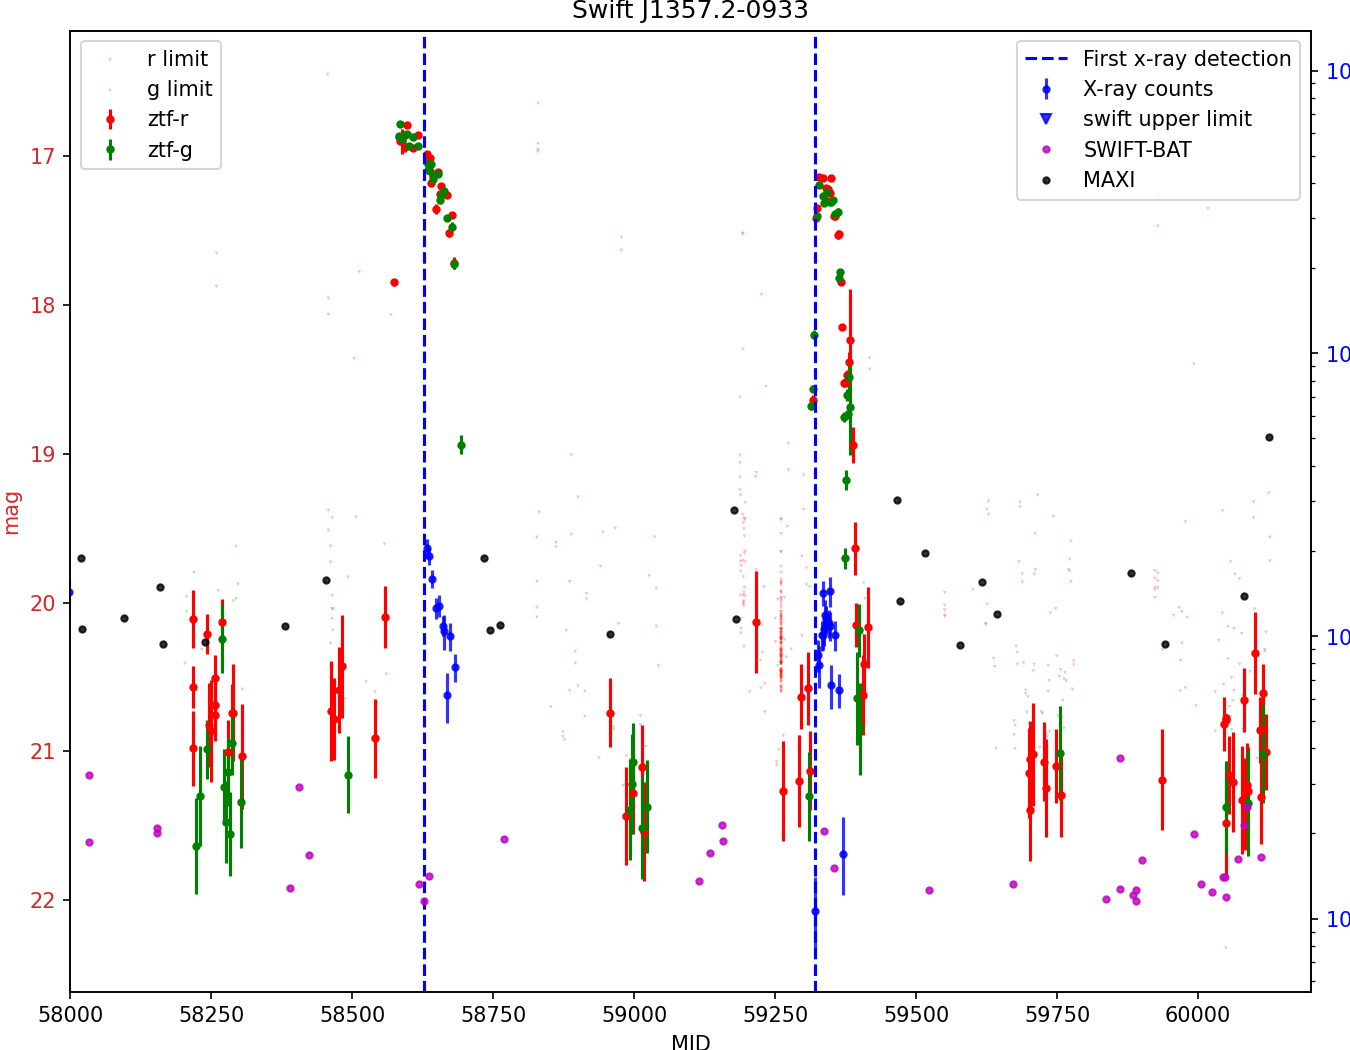

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 12801, 14573
https://www.astronomerstelegram.org/?read=12801
https://www.astronomerstelegram.org/?read=14573


<IPython.core.display.Javascript object>


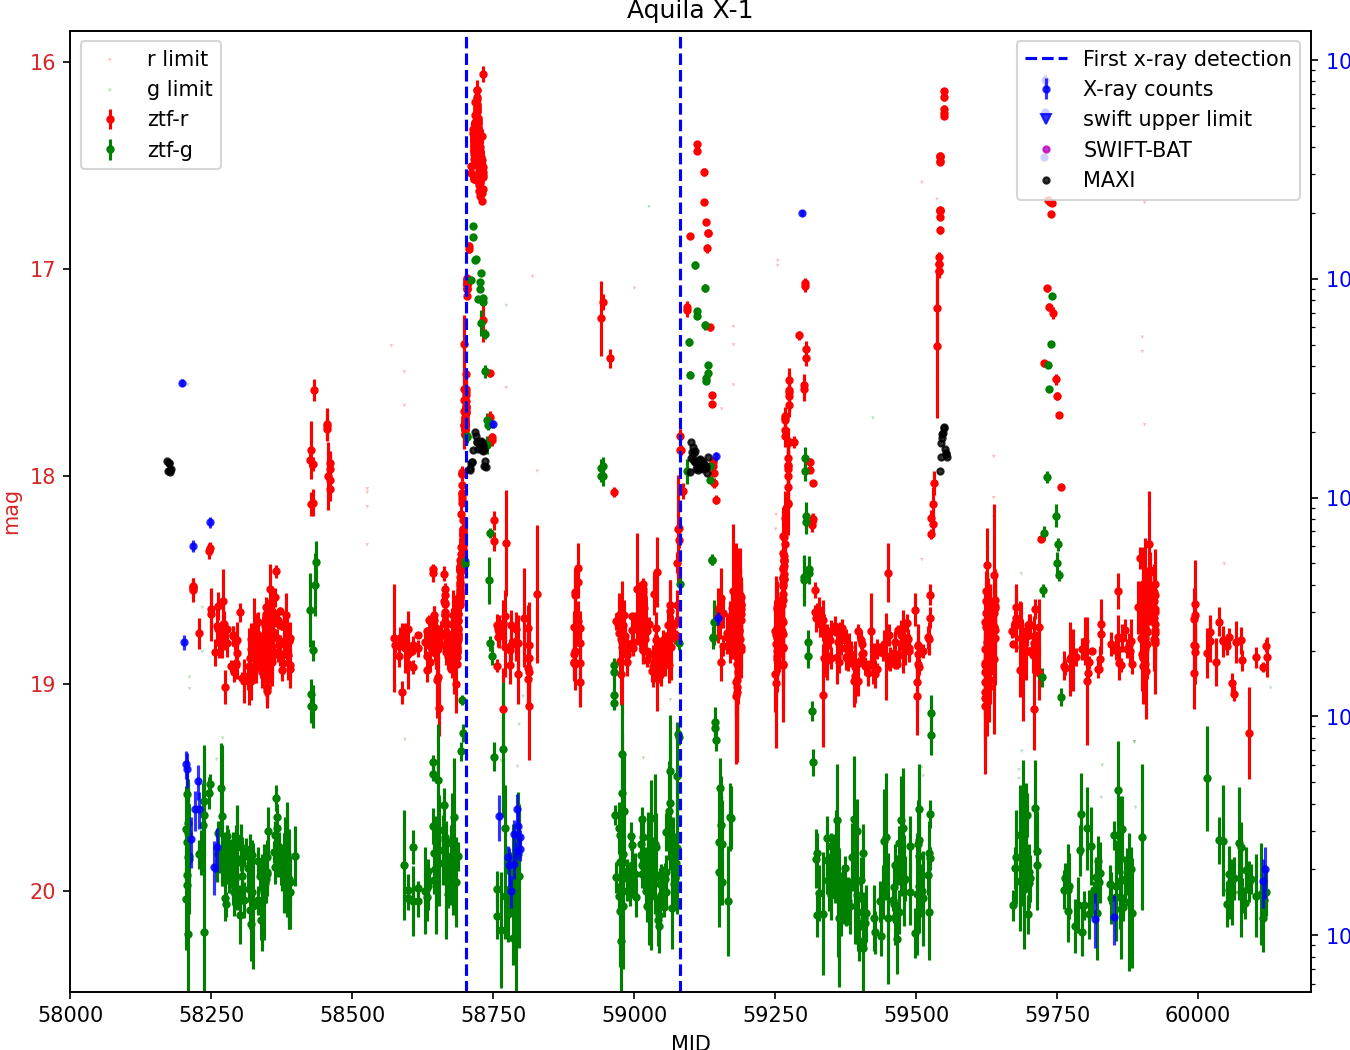

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 13016, 13961
https://www.astronomerstelegram.org/?read=13016
https://www.astronomerstelegram.org/?read=13961


<IPython.core.display.Javascript object>


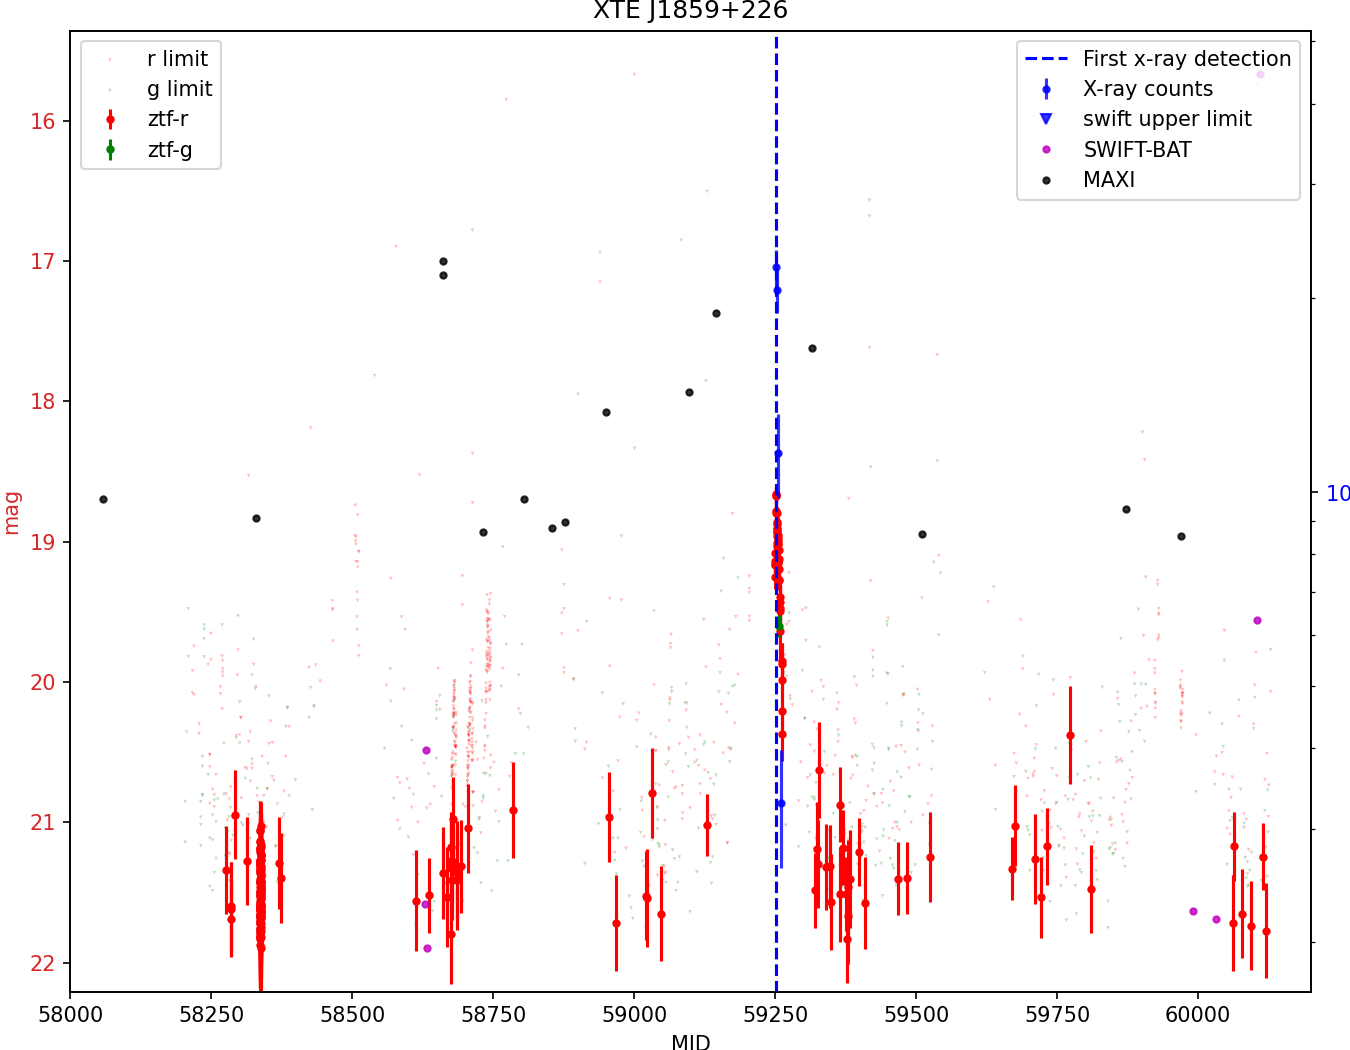

C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 14375
https://www.astronomerstelegram.org/?read=14375


<IPython.core.display.Javascript object>


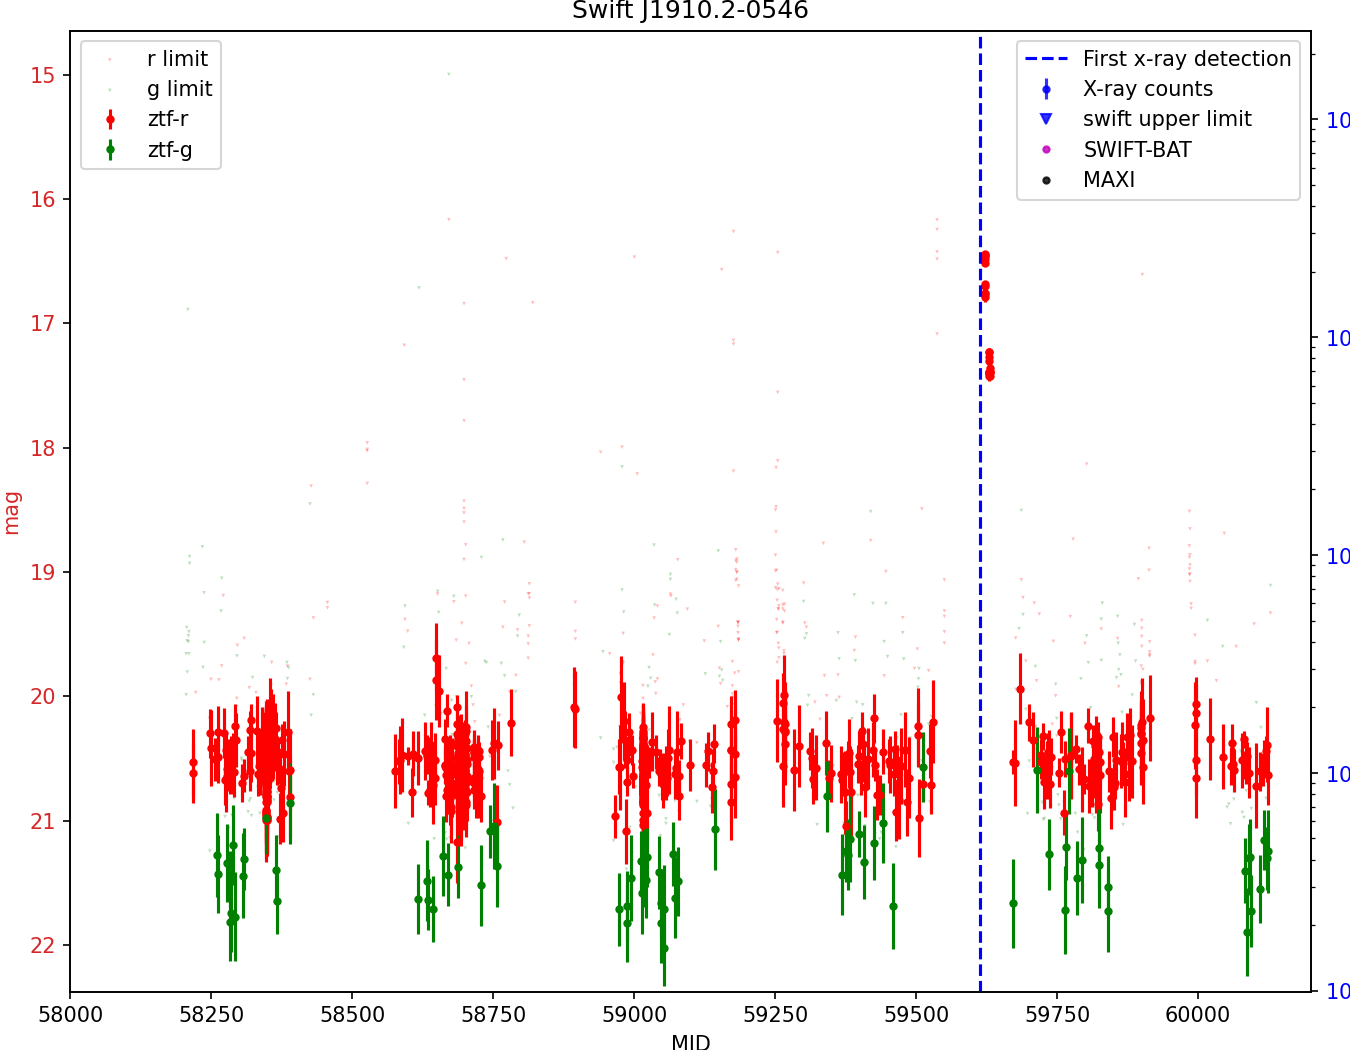

C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 15214
https://www.astronomerstelegram.org/?read=15214


<IPython.core.display.Javascript object>


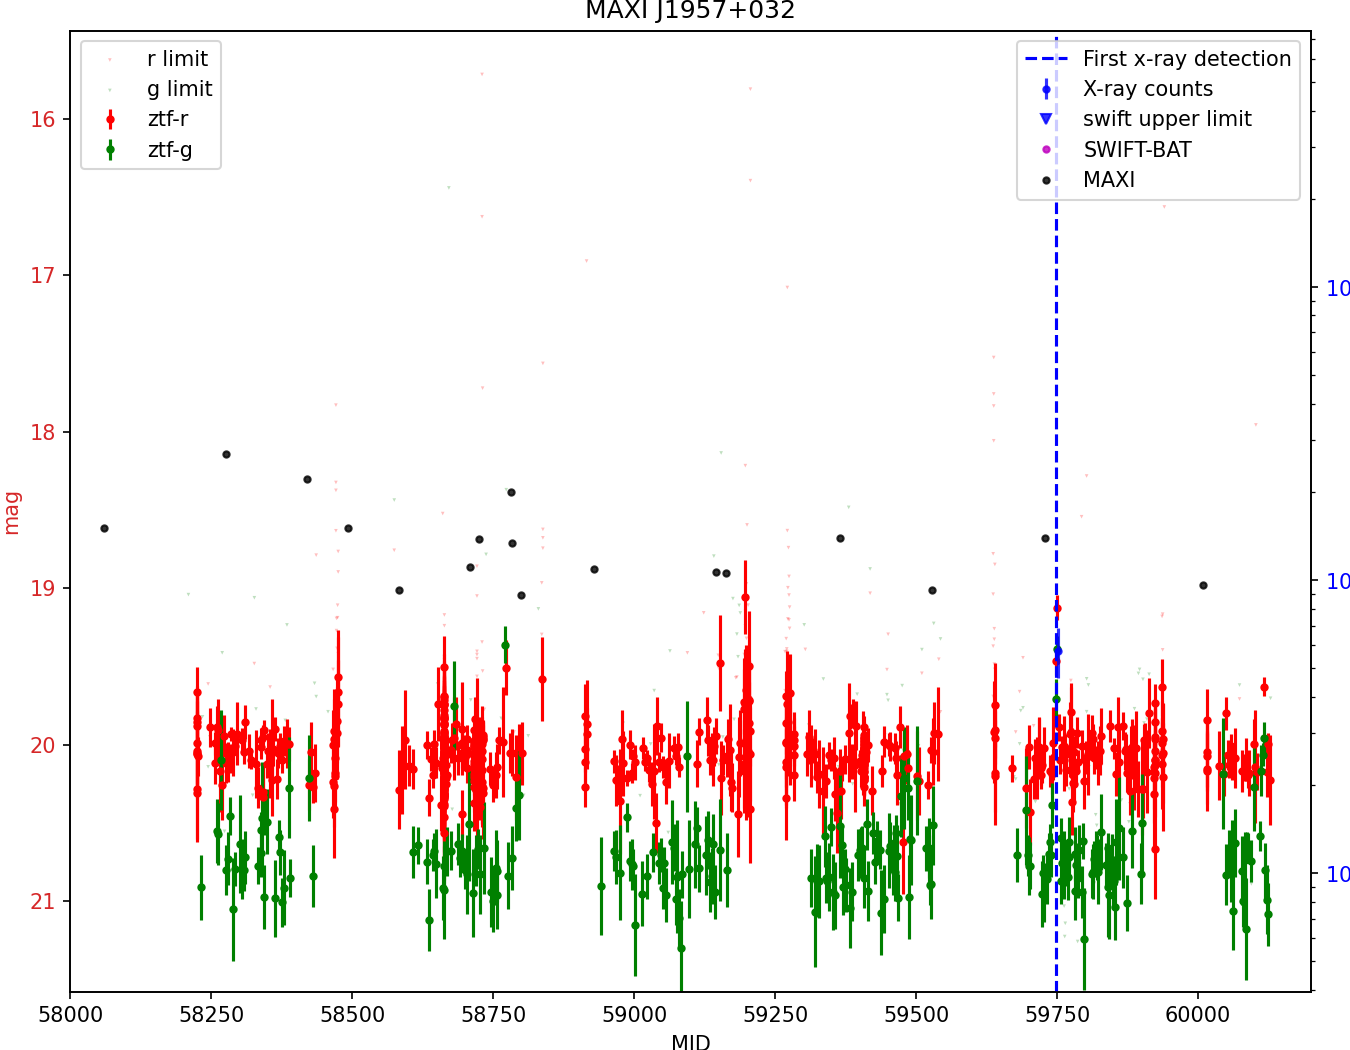

C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 15440
https://www.astronomerstelegram.org/?read=15440


<IPython.core.display.Javascript object>


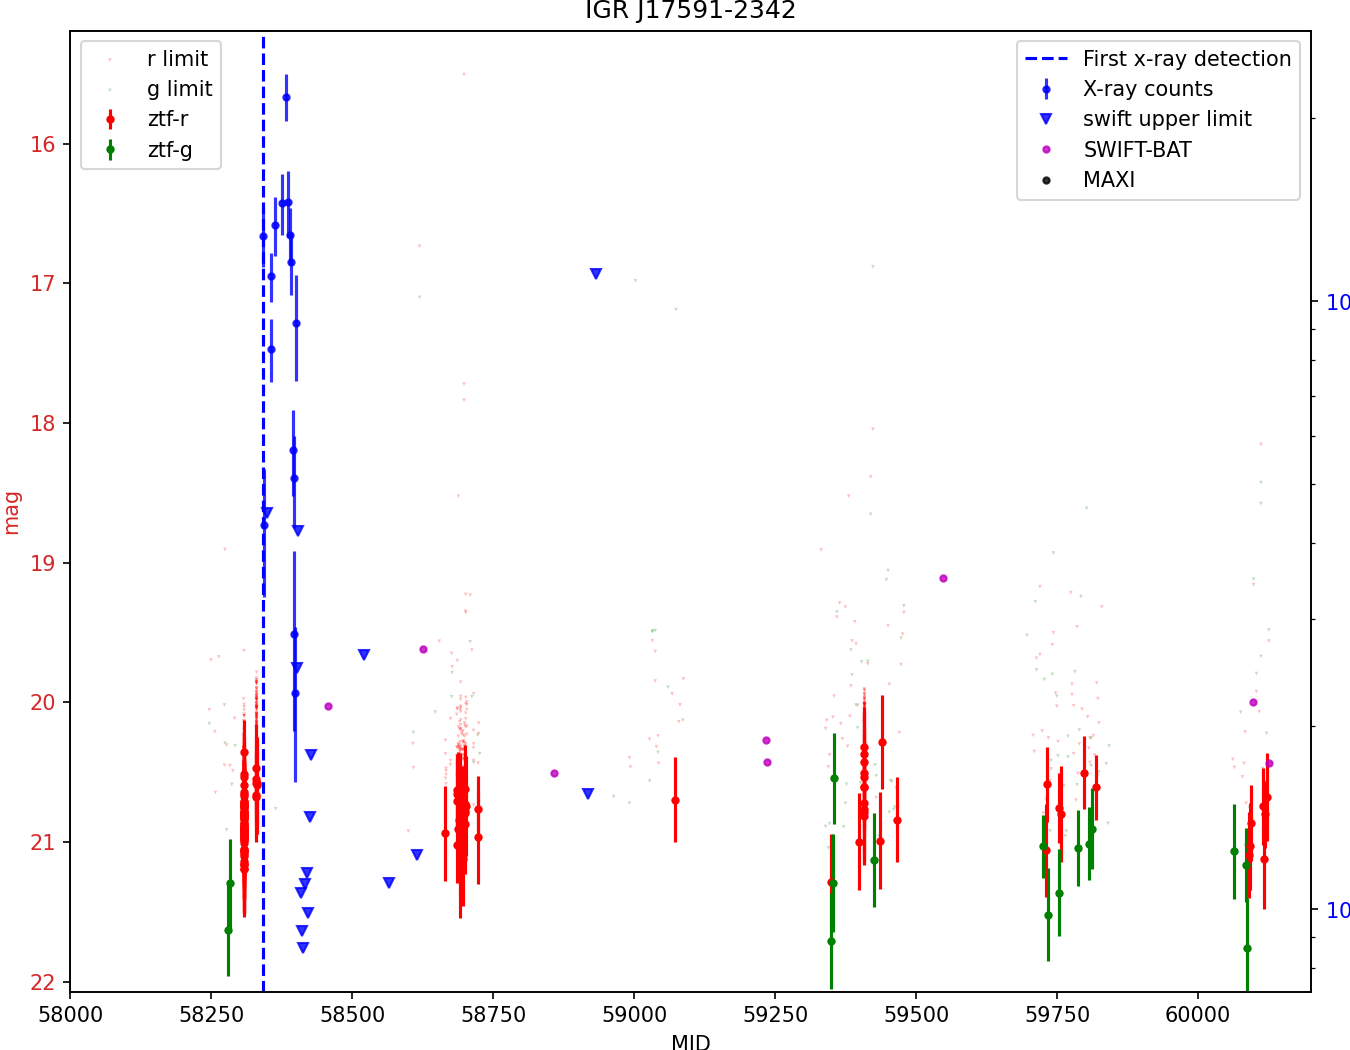

C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 11941
https://www.astronomerstelegram.org/?read=11941


<IPython.core.display.Javascript object>


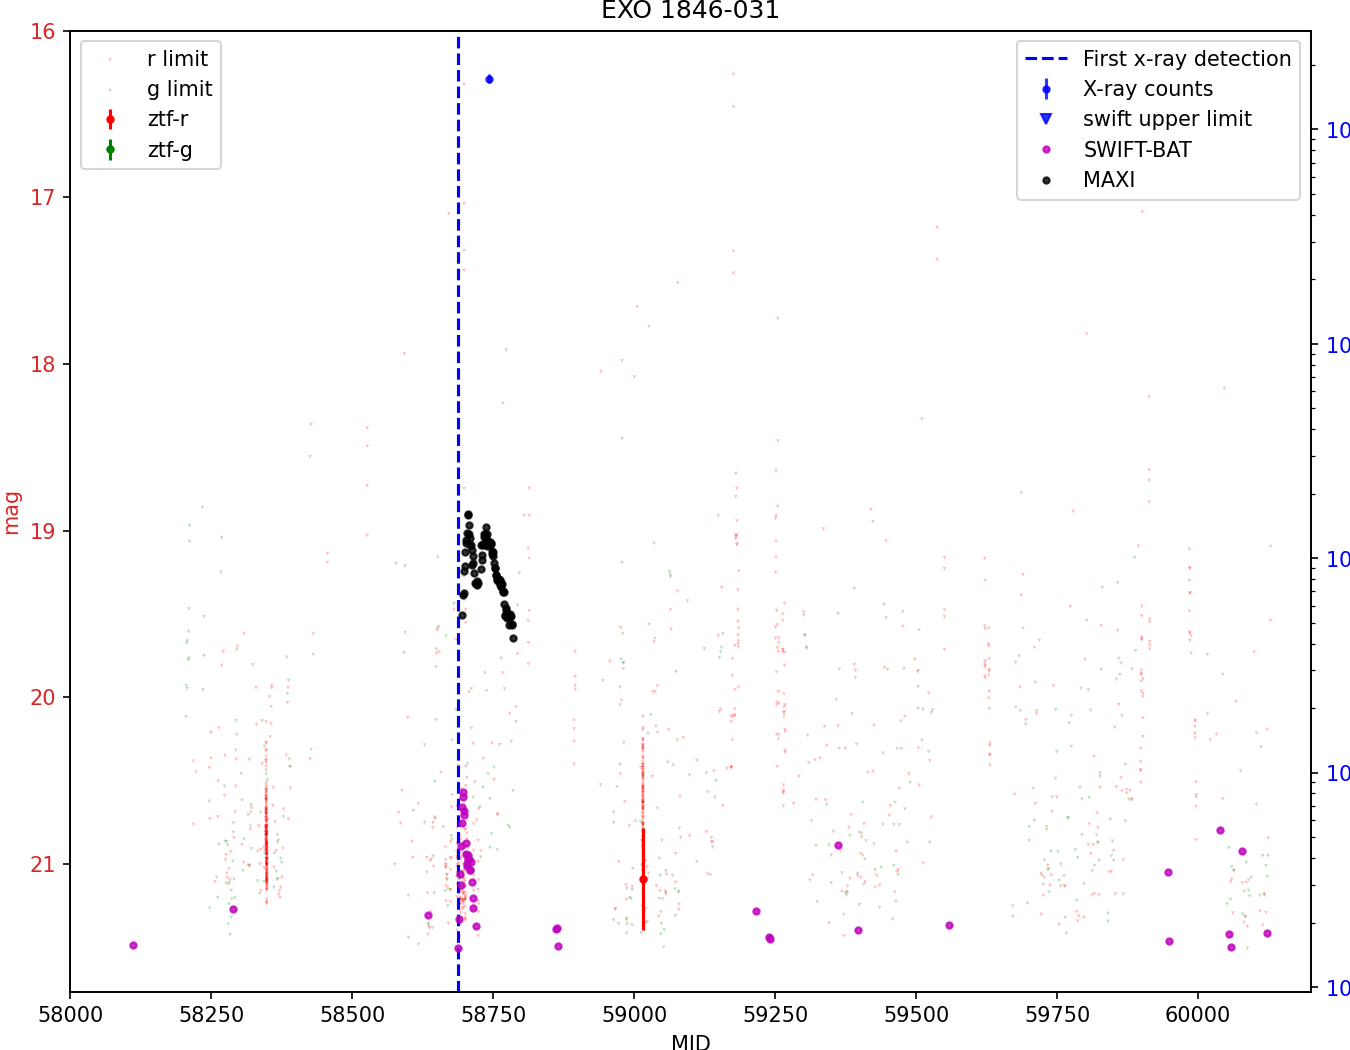

C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 12968
https://www.astronomerstelegram.org/?read=12968


<IPython.core.display.Javascript object>


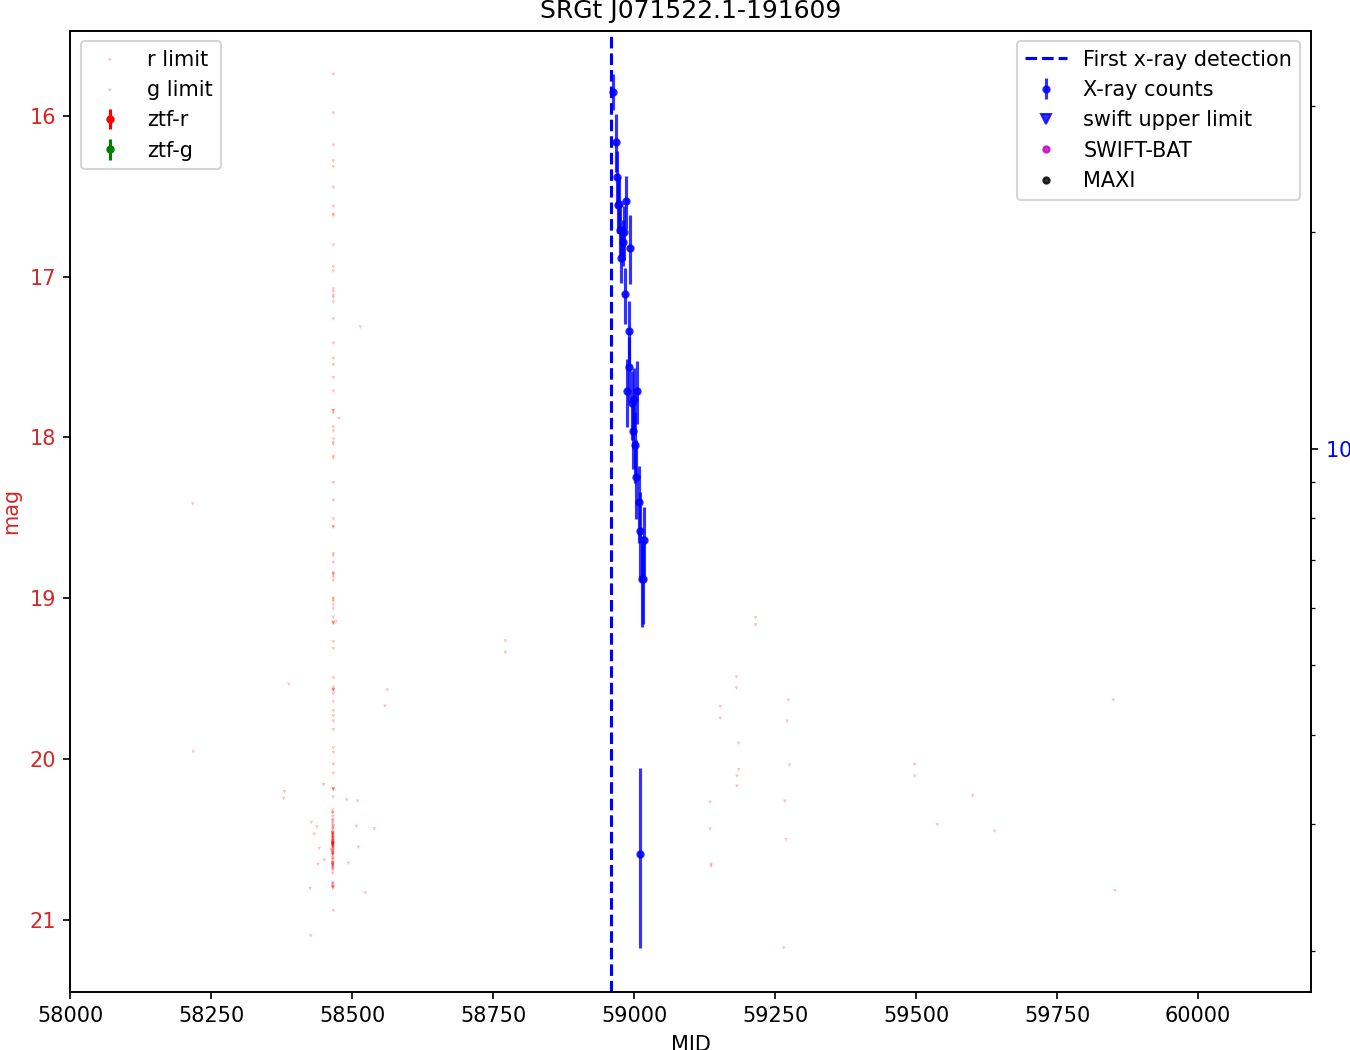

C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 13657
https://www.astronomerstelegram.org/?read=13657


<IPython.core.display.Javascript object>


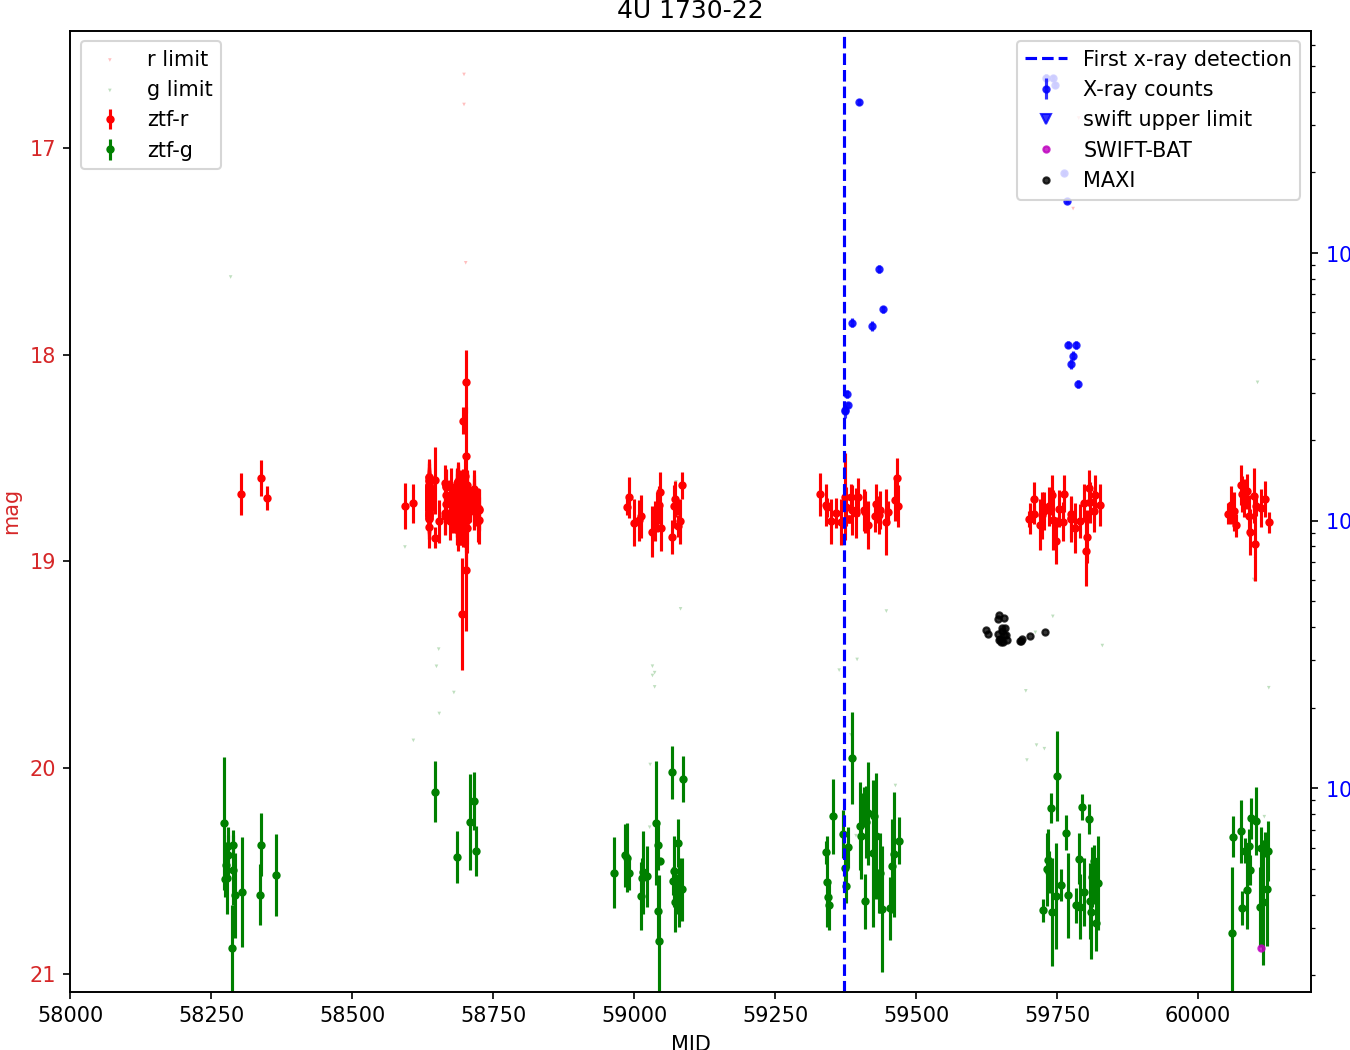

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 14683
https://www.astronomerstelegram.org/?read=14683


<IPython.core.display.Javascript object>


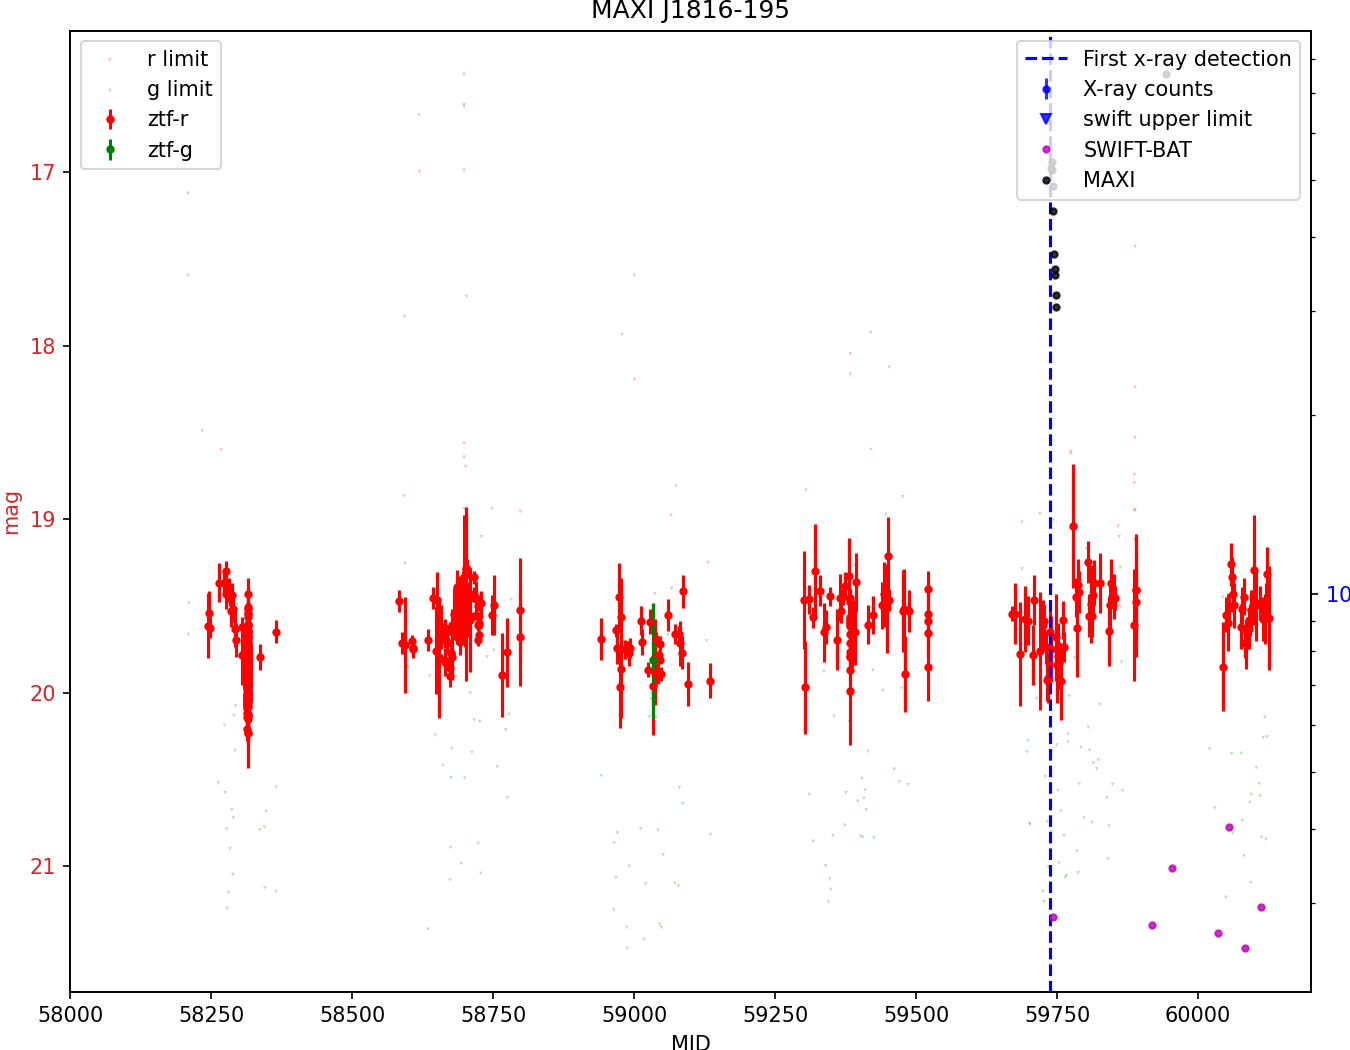

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 15418
https://www.astronomerstelegram.org/?read=15418


<IPython.core.display.Javascript object>


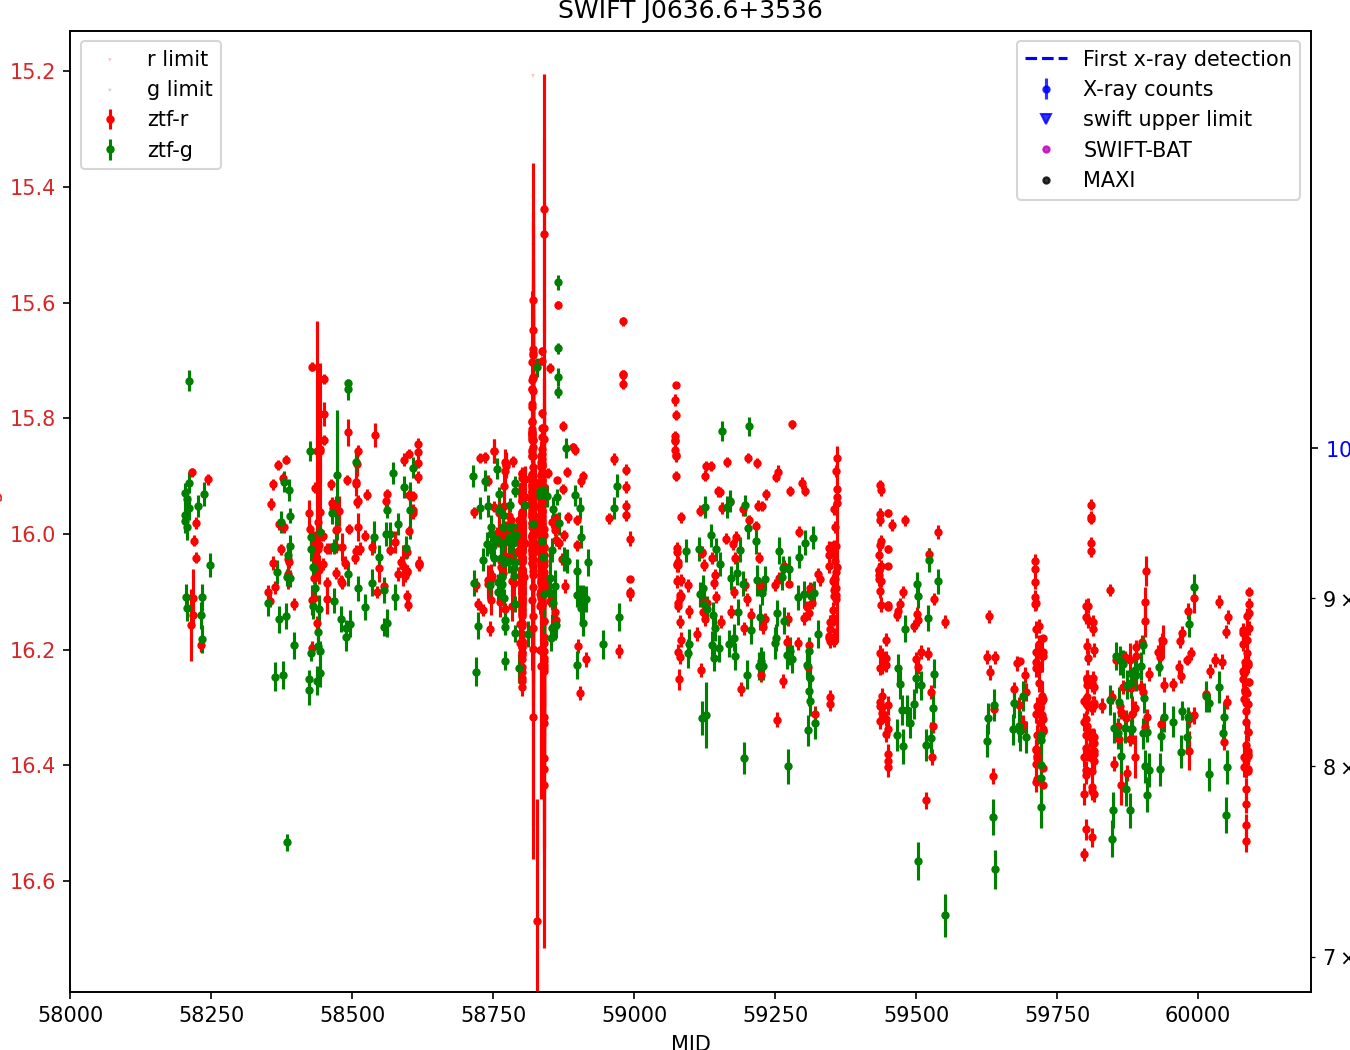

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 0
https://www.astronomerstelegram.org/?read=0


<IPython.core.display.Javascript object>


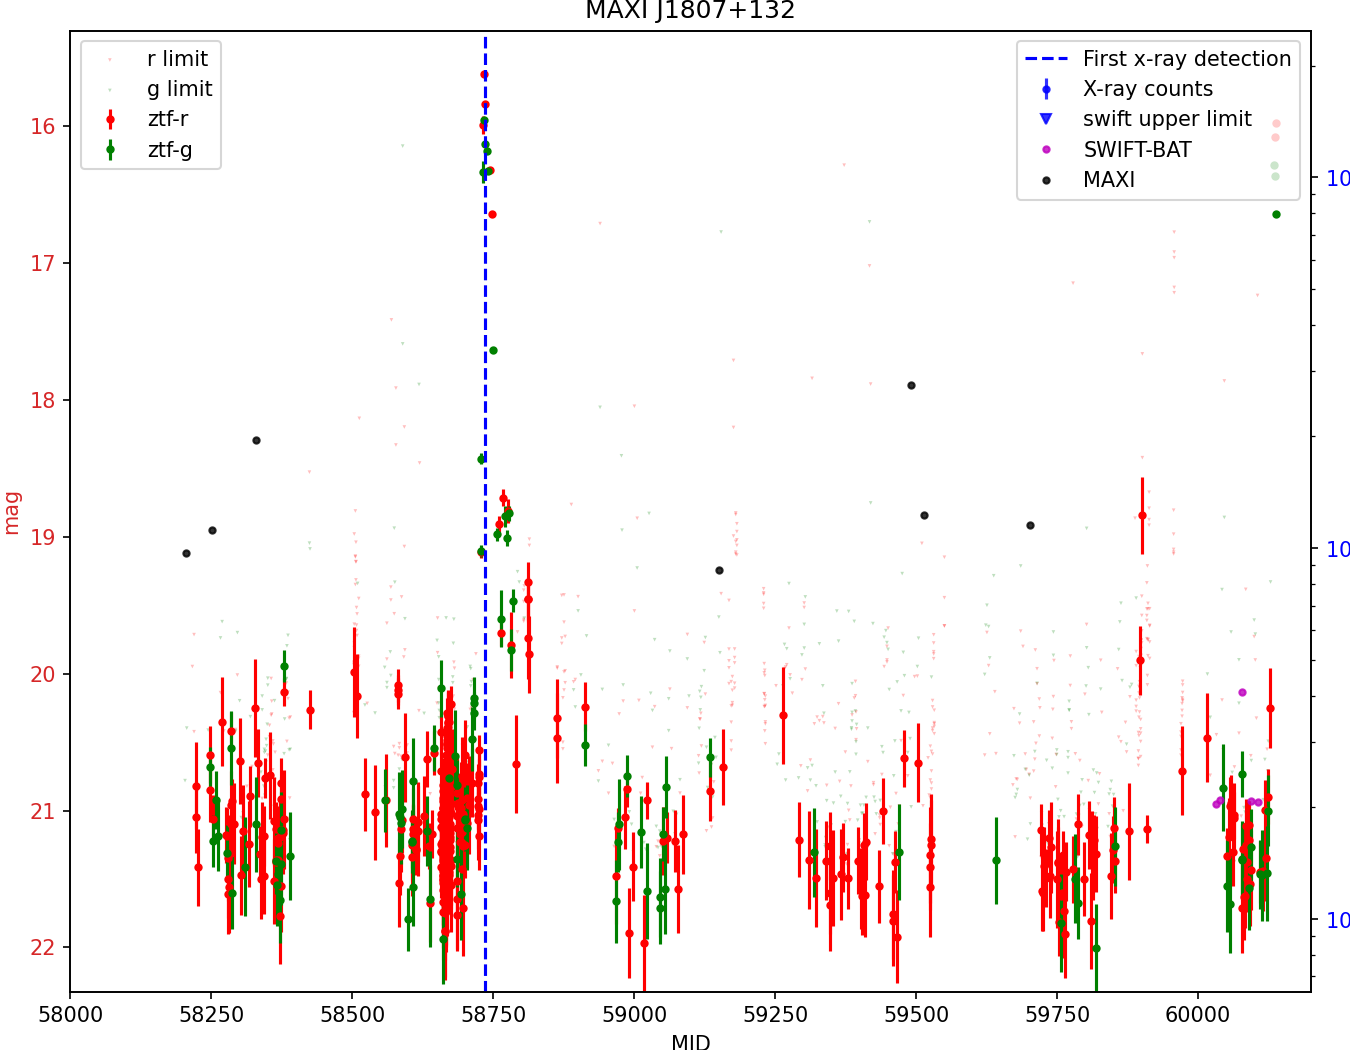

C:\Users\allis\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\allis\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Atel: 13097
https://www.astronomerstelegram.org/?read=13097


In [4]:
for source, t, t2, atel, atel2 in zip(sources.name, sources.time, sources.time2, sources.A_tel, sources.A_tel2):
    xray_overplot(obj=source, start_time=t, start_time2=t2)
    if atel2 !=0:
        print(f"Atel: {atel}, {atel2}")
        print(f'https://www.astronomerstelegram.org/?read={atel}')
        print(f'https://www.astronomerstelegram.org/?read={atel2}')
    else:
        print(f"Atel: {atel}")
        print(f'https://www.astronomerstelegram.org/?read={atel}')

# Notes and tests

### Swift single

In [5]:
file = 'Aquila X-1_xray.txt'
swift = pd.read_csv(f'swift_data/{file}', sep="\s+", skiprows=[0,1,2,3,4,5,6,7])
swift.rename(columns={"!MJD":"MJD", "T_+ve":"Tpos", "T_-ve":"Tneg"}, inplace=True)

# delete comment & blank rows
blank_rows = np.append(swift.query('MJD == "!"').index.values, swift.query('MJD == "NO"').index.values)
swift.drop(blank_rows, inplace=True)

# change column values from strings to floats
for i in swift.columns:
    swift[f'{i}'] = pd.to_numeric(swift[f'{i}'])
    
# set errorbar values
ybars=(-swift['Rateneg'], swift['Ratepos'])
xbars=(-swift['Tneg'], swift['Tpos'])

# x-ray plot
fig,ax = plt.subplots(1,1)
fig.set_size_inches(9,7)
fig.tight_layout()

ax.errorbar(swift['MJD'], swift['Rate'], yerr=ybars, xerr=xbars, fmt='o', color='blue', markersize=4, label='X-ray counts')
ax.set_title(file[:-9])
ax.set_ylabel('Count Rate')
ax.set_xlabel('MJD')
ax.legend()

UndefinedVariableError: name 'MJD' is not defined

### swift loop

In [ ]:
swift_dir = 'swift_data/'

In [ ]:
for file in [x for x in os.listdir(swift_dir) if '.txt' in x]:

    swift = pd.read_csv(f'swift_data/{file}', sep="\s+", skiprows=[0,1,2,3,4,5,6,7])
    swift.rename(columns={"!MJD":"MJD", "T_+ve":"Tpos", "T_-ve":"Tneg"}, inplace=True)

    # delete comment & blank rows
    blank_rows = np.append(swift.query('MJD == "!"').index.values, swift.query('MJD == "NO"').index.values)
    swift.drop(blank_rows, inplace=True)

    # change column values from strings to floats
    for i in swift.columns:
        swift[f'{i}'] = pd.to_numeric(swift[f'{i}'])

    # set errorbar values
    ybars=(-swift['Rateneg'], swift['Ratepos'])
    xbars=(-swift['Tneg'], swift['Tpos'])

    # plot
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(9,7)
    fig.tight_layout()

    ax.errorbar(swift['MJD'], swift['Rate'], yerr=ybars, xerr=xbars, fmt='o', color='blue', markersize=4, label='X-ray counts')
    ax.set_title(file[:-9])
    ax.set_ylabel('Count Rate')
    ax.set_xlabel('MJD')
    ax.legend()

### ZTF single

In [ ]:
phot_file = 'ztf_data/Aquila X-1.txt'
colors = ['green', 'pink', 'red']

ztf_fp = get_lightcurve(phot_file)
    
plt.figure(figsize=(9.6,7.2))
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
             ztf_fp.loc[wr,'dc_mag_err'],fmt='o',ls='none', color=colors[2], label='ztf-r')
plt.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[2])
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
             ztf_fp.loc[wg,'dc_mag_err'],fmt='o',ls='none', color=colors[0], label='ztf-g')
plt.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[0])

plt.title(phot_file[5:-4])
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### ZTF loop

In [ ]:
DATA_DIR = 'ztf_data/'

In [ ]:
data = []
colors = ['green', 'pink', 'red']
for f in [x for x in os.listdir(DATA_DIR) if '.txt' in x]:
    ztf_fp = get_lightcurve(DATA_DIR+f)
    
    plt.figure(figsize=(9.6,7.2))
    wr = ztf_fp['filter'] == 'ZTF_r'
    wg = ztf_fp['filter'] == 'ZTF_g'

    plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
                 ztf_fp.loc[wr,'dc_mag_err'],fmt='o',ls='none', color=colors[2], label='ztf-r')
    plt.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25,
                edgecolor='none',color=colors[2])
    plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
                 ztf_fp.loc[wg,'dc_mag_err'],fmt='o',ls='none', color=colors[0], label='ztf-g')
    plt.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25,
                edgecolor='none',color=colors[0])

    plt.title(f[:-4])
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

### Overplot single

<IPython.core.display.Javascript object>


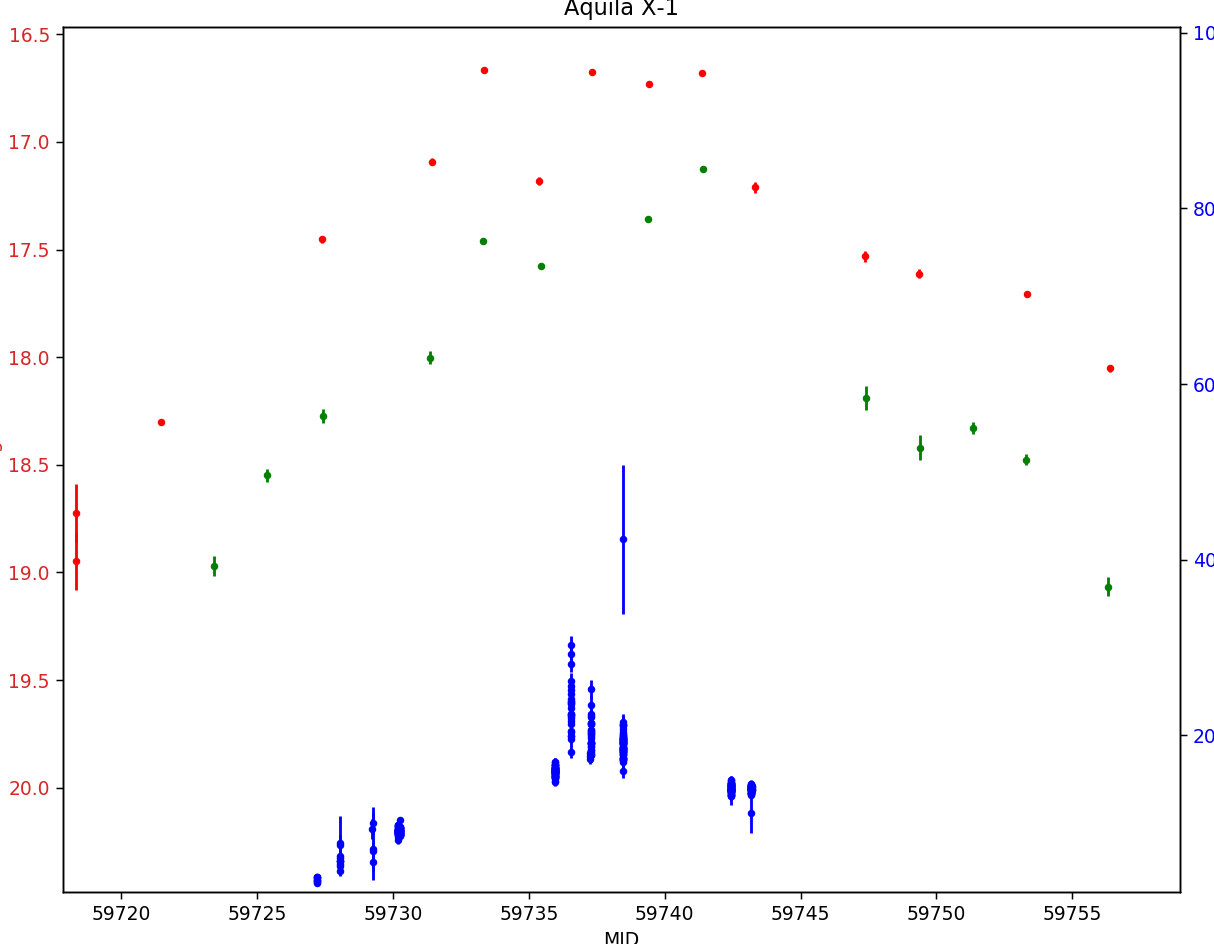

In [45]:
fig, ax1 = plt.subplots()
fig.set_size_inches(9,7)
fig.tight_layout()

# ZTF optical
color = 'tab:red'
ax1.set_xlabel('MJD')
ax1.set_ylabel('mag', color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_title(phot_file[5:-4])
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

mkr_size = 3

ax1.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
             ztf_fp.loc[wr,'dc_mag_err'],fmt='o',ls='none', markersize=mkr_size, color=colors[2], label='ztf-r')
ax1.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25, s=mkr_size,
            edgecolor='none',color=colors[2])
ax1.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
             ztf_fp.loc[wg,'dc_mag_err'],fmt='o',ls='none', markersize=mkr_size,color=colors[0], label='ztf-g')
ax1.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25, s=mkr_size,
            edgecolor='none',color=colors[0])

#ax1.legend()
ax1.invert_yaxis()

# SWIFT x-ray

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'blue'
ax2.set_ylabel('Count Rate', color=color2)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)
ax2.errorbar(swift['MJD'], swift['Rate'], yerr=ybars, xerr=xbars, fmt='o', color=color2, markersize= mkr_size, label='X-ray counts')


#ax1.legend(loc=2)
#ax2.legend(loc=1)
plt.title(file[:-9])
plt.show()

### URL

In [ ]:
from IPython.display import Image,display, HTML

def make_ipac_url(ra, dec):
    return f"https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?spatial=cone&catalog=ztf_objects_dr14&objstr={ra}%20{dec}&radius=1.5&radunits=arcsec&outfmt=0"

def make_link(row):
    url=make_ipac_url(row["ra"], row["dec"])
    return f"""<a href={url} target="_blank">IPAC link</a> for {row['axs_id']} at {row['ra']}, {row['dec']}"""

for index, row in true_sources[index:index+1].iterrows():
    display(HTML(make_link(row)))